In [1]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import os.path as p
%matplotlib inline

In [2]:
datasource_path = "UrbanSound8k"
audio_source = p.join(datasource_path, "audio")
metadata_path = p.join(p.join(datasource_path, "metadata"),"UrbanSound8k.csv")
metadata = pd.read_csv(metadata_path, index_col="fsID")
spectro_path = p.join("UrbanSound8k", "spectrogram")
folds = ["fold{}".format(str(i)) for i in range(1,11)]

metadata[:5]

,slice_file_name,start,end,salience,fold,classID,class
fsID,,,,,,,
100032,100032-3-0-0.wav,0.0,0.317551,1,5,3,dog_bark
100263,100263-2-0-117.wav,58.5,62.500000,1,5,2,children_playing
100263,100263-2-0-121.wav,60.5,64.500000,1,5,2,children_playing
100263,100263-2-0-126.wav,63.0,67.000000,1,5,2,children_playing
100263,100263-2-0-137.wav,68.5,72.500000,1,5,2,children_playing


In [3]:
def create_folders():
    to_create =[spectro_path]+ [p.join(spectro_path, fold) for fold in folds]
    
    for dirName in to_create:
        try:
            # Create target Directory
            os.mkdir(dirName)
            print("Directory " , dirName ,  " Created ") 
        except FileExistsError:
            print("Directory " , dirName ,  " already exists")

create_folders()

Directory  UrbanSound8k\spectrogram  already exists
Directory  UrbanSound8k\spectrogram\fold1  already exists
Directory  UrbanSound8k\spectrogram\fold2  already exists
Directory  UrbanSound8k\spectrogram\fold3  already exists
Directory  UrbanSound8k\spectrogram\fold4  already exists
Directory  UrbanSound8k\spectrogram\fold5  already exists
Directory  UrbanSound8k\spectrogram\fold6  already exists
Directory  UrbanSound8k\spectrogram\fold7  already exists
Directory  UrbanSound8k\spectrogram\fold8  already exists
Directory  UrbanSound8k\spectrogram\fold9  already exists
Directory  UrbanSound8k\spectrogram\fold10  already exists


In [4]:
def plot_spectrogram(filename):
    plt.interactive(False)
    filename, _ = build_path(filename)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig, ax = plt.subplots()
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()

    
def create_spectrogram(filename):
    plt.interactive(False)
    filename, fold_id =build_path(filename)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    curr_path = p.join(spectro_path, folds[fold_id])
    savefile  = p.join(curr_path, "{}.jpg".format(p.basename(filename).split(".")[0] ))
    plt.savefig(savefile, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,clip,sample_rate,fig,ax,S,savefile
    
def build_path(file_name, spectrogram = False):
    file=file_name.split(".")
    source = spectro_path if spectrogram else audio_source
    file_name = file[0] + ".jpg" if spectrogram else file[0] +".wav"
    fsID= int(file_name.split("-")[0])
    frame = metadata.loc[fsID]
    fold_id = 0
    try:
        fold_id = frame["fold"].values[0]-1
    except:
        fold_id = frame["fold"] -1
    file_with_fold = p.join(folds[fold_id], file_name)
    return p.join(source,file_with_fold), fold_id

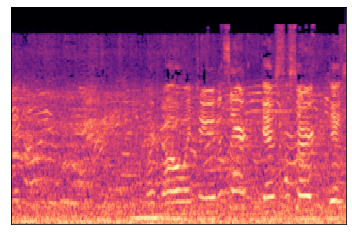

In [5]:
create_spectrogram("100263-2-0-126..wav")
plot_spectrogram("100263-2-0-126..wav")

In [6]:
from tqdm import tqdm_notebook

import gc
counter = 0
errors =0
for index, row in tqdm_notebook(metadata.iterrows()):
    counter += 1
    if counter%2000 ==0:
        gc.collect()
    try:
        file_name = row["slice_file_name"]
        s,_ = build_path(file_name, True)
        metadata.loc[index, "spectro_path"] = s
        if not p.exists(s): create_spectrogram(file_name)
    except Exception as e:
        errors +=1

print(counter)
print(errors)
print(counter - errors)
metadata[:5]


8732
107
8625


,slice_file_name,start,end,salience,fold,classID,class,spectro_path
fsID,,,,,,,,
100032,100032-3-0-0.wav,0.0,0.317551,1,5,3,dog_bark,UrbanSound8k\spectrogram\fold5\100032-3-0-0.jpg
100263,100263-2-0-117.wav,58.5,62.500000,1,5,2,children_playing,UrbanSound8k\spectrogram\fold5\100263-2-0-36.jpg
100263,100263-2-0-121.wav,60.5,64.500000,1,5,2,children_playing,UrbanSound8k\spectrogram\fold5\100263-2-0-36.jpg
100263,100263-2-0-126.wav,63.0,67.000000,1,5,2,children_playing,UrbanSound8k\spectrogram\fold5\100263-2-0-36.jpg
100263,100263-2-0-137.wav,68.5,72.500000,1,5,2,children_playing,UrbanSound8k\spectrogram\fold5\100263-2-0-36.jpg


In [7]:
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from sklearn.model_selection import StratifiedKFold


Using TensorFlow backend.
c:\users\anton\anaconda3\envs\ml-agents\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\anton\anaconda3\envs\ml-agents\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\anton\anaconda3\envs\ml-agents\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\anton\anaconda3\envs\ml-ag

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D,Flatten, MaxPooling2D, Dropout
def get_fold(idx):
    return metadata[metadata.fold == index]

def get_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=2, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

In [ ]:
datagen=ImageDataGenerator(rescale=1./255)
for j in range(10):
    test_mask = (metadata.fold != j)
    valid_mask = (metadata.fold != j)

    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    train_generator=datagen.flow_from_dataframe(dataframe=metadata[test_mask], 
                                                directory="./", x_col="spectro_path", 
                                                y_col="class", class_mode="categorical", 
                                                target_size=(64,64), batch_size=32)
    validation_generator=datagen.flow_from_dataframe(dataframe=metadata[valid_mask], 

                                                directory="./", x_col="spectro_path", 
                                                y_col="class", class_mode="categorical", 
                                                target_size=(64,64), batch_size=32)

    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    model = get_model()
    model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

    model.fit_generator(
                train_generator,

                epochs=15,
                
                verbose=1,
                validation_data = validation_generator, 

                callbacks = callbacks)

c:\users\anton\anaconda3\envs\ml-agents\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 152 invalid image filename(s) in x_col="spectro_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 8580 validated image filenames belonging to 10 classes.
Found 8580 validated image filenames belonging to 10 classes.


c:\users\anton\anaconda3\envs\ml-agents\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/15
269/269 [==============================] - ETA: 10:20 - loss: 2.2900 - acc: 0.15 - ETA: 2:37 - loss: 2.3717 - acc: 0.1328 - ETA: 1:31 - loss: 2.3389 - acc: 0.151 - ETA: 1:04 - loss: 2.3155 - acc: 0.143 - ETA: 50s - loss: 2.3057 - acc: 0.149 - ETA: 41s - loss: 2.3019 - acc: 0.13 - ETA: 35s - loss: 2.2940 - acc: 0.12 - ETA: 30s - loss: 2.2843 - acc: 0.13 - ETA: 27s - loss: 2.2766 - acc: 0.13 - ETA: 24s - loss: 2.2736 - acc: 0.13 - ETA: 22s - loss: 2.2645 - acc: 0.13 - ETA: 20s - loss: 2.2679 - acc: 0.14 - ETA: 18s - loss: 2.2583 - acc: 0.14 - ETA: 17s - loss: 2.2502 - acc: 0.15 - ETA: 16s - loss: 2.2422 - acc: 0.15 - ETA: 15s - loss: 2.2293 - acc: 0.16 - ETA: 14s - loss: 2.2181 - acc: 0.16 - ETA: 13s - loss: 2.2169 - acc: 0.16 - ETA: 13s - loss: 2.2112 - acc: 0.16 - ETA: 12s - loss: 2.1954 - acc: 0.17 - ETA: 11s - loss: 2.1868 - acc: 0.17 - ETA: 11s - loss: 2.1795 - acc: 0.17 - ETA: 10s - loss: 2.1750 - acc: 0.17 - ETA: 10s - loss: 2.1629 - acc: 0.17 - ETA: 9s - loss: 2.1570 -

269/269 [==============================] - ETA: 4s - loss: 1.1108 - acc: 0.625 - ETA: 5s - loss: 0.8515 - acc: 0.710 - ETA: 4s - loss: 0.8689 - acc: 0.692 - ETA: 4s - loss: 0.8540 - acc: 0.712 - ETA: 4s - loss: 0.7982 - acc: 0.733 - ETA: 4s - loss: 0.8299 - acc: 0.728 - ETA: 4s - loss: 0.8134 - acc: 0.731 - ETA: 4s - loss: 0.8399 - acc: 0.728 - ETA: 4s - loss: 0.8306 - acc: 0.730 - ETA: 4s - loss: 0.8307 - acc: 0.725 - ETA: 4s - loss: 0.8235 - acc: 0.725 - ETA: 4s - loss: 0.8060 - acc: 0.730 - ETA: 4s - loss: 0.8110 - acc: 0.729 - ETA: 4s - loss: 0.8084 - acc: 0.736 - ETA: 4s - loss: 0.8000 - acc: 0.741 - ETA: 4s - loss: 0.7912 - acc: 0.741 - ETA: 4s - loss: 0.7945 - acc: 0.744 - ETA: 4s - loss: 0.8236 - acc: 0.736 - ETA: 4s - loss: 0.8262 - acc: 0.733 - ETA: 4s - loss: 0.8205 - acc: 0.734 - ETA: 4s - loss: 0.8226 - acc: 0.735 - ETA: 3s - loss: 0.8203 - acc: 0.734 - ETA: 3s - loss: 0.8328 - acc: 0.729 - ETA: 3s - loss: 0.8232 - acc: 0.731 - ETA: 3s - loss: 0.8163 - acc: 0.733 - ETA: 3s

269/269 [==============================] - ETA: 5s - loss: 0.2220 - acc: 0.937 - ETA: 5s - loss: 0.3653 - acc: 0.921 - ETA: 5s - loss: 0.3711 - acc: 0.897 - ETA: 4s - loss: 0.3780 - acc: 0.893 - ETA: 5s - loss: 0.3684 - acc: 0.889 - ETA: 4s - loss: 0.4178 - acc: 0.869 - ETA: 4s - loss: 0.4004 - acc: 0.873 - ETA: 4s - loss: 0.3808 - acc: 0.876 - ETA: 4s - loss: 0.3578 - acc: 0.883 - ETA: 4s - loss: 0.3492 - acc: 0.887 - ETA: 4s - loss: 0.3437 - acc: 0.890 - ETA: 4s - loss: 0.3508 - acc: 0.887 - ETA: 4s - loss: 0.3710 - acc: 0.880 - ETA: 4s - loss: 0.3862 - acc: 0.874 - ETA: 4s - loss: 0.3888 - acc: 0.874 - ETA: 4s - loss: 0.3901 - acc: 0.875 - ETA: 4s - loss: 0.3817 - acc: 0.878 - ETA: 4s - loss: 0.3730 - acc: 0.881 - ETA: 4s - loss: 0.3678 - acc: 0.883 - ETA: 4s - loss: 0.3780 - acc: 0.880 - ETA: 4s - loss: 0.3835 - acc: 0.878 - ETA: 4s - loss: 0.3758 - acc: 0.880 - ETA: 3s - loss: 0.3708 - acc: 0.881 - ETA: 3s - loss: 0.3719 - acc: 0.880 - ETA: 3s - loss: 0.3702 - acc: 0.881 - ETA: 3s

269/269 [==============================] - ETA: 5s - loss: 0.1661 - acc: 0.937 - ETA: 5s - loss: 0.1777 - acc: 0.953 - ETA: 5s - loss: 0.1922 - acc: 0.950 - ETA: 5s - loss: 0.1729 - acc: 0.946 - ETA: 5s - loss: 0.2047 - acc: 0.930 - ETA: 5s - loss: 0.2296 - acc: 0.925 - ETA: 5s - loss: 0.2118 - acc: 0.932 - ETA: 4s - loss: 0.2507 - acc: 0.929 - ETA: 4s - loss: 0.2423 - acc: 0.932 - ETA: 4s - loss: 0.2285 - acc: 0.934 - ETA: 4s - loss: 0.2218 - acc: 0.934 - ETA: 4s - loss: 0.2213 - acc: 0.934 - ETA: 4s - loss: 0.2104 - acc: 0.938 - ETA: 4s - loss: 0.2044 - acc: 0.939 - ETA: 4s - loss: 0.2078 - acc: 0.937 - ETA: 4s - loss: 0.2257 - acc: 0.932 - ETA: 4s - loss: 0.2259 - acc: 0.932 - ETA: 4s - loss: 0.2174 - acc: 0.935 - ETA: 4s - loss: 0.2157 - acc: 0.937 - ETA: 4s - loss: 0.2162 - acc: 0.937 - ETA: 4s - loss: 0.2157 - acc: 0.937 - ETA: 3s - loss: 0.2112 - acc: 0.938 - ETA: 3s - loss: 0.2060 - acc: 0.939 - ETA: 3s - loss: 0.2020 - acc: 0.941 - ETA: 3s - loss: 0.1983 - acc: 0.940 - ETA: 3s

269/269 [==============================] - ETA: 5s - loss: 0.1213 - acc: 0.968 - ETA: 5s - loss: 0.1025 - acc: 0.960 - ETA: 5s - loss: 0.0882 - acc: 0.968 - ETA: 5s - loss: 0.1256 - acc: 0.959 - ETA: 5s - loss: 0.1375 - acc: 0.951 - ETA: 5s - loss: 0.1359 - acc: 0.953 - ETA: 4s - loss: 0.1387 - acc: 0.952 - ETA: 4s - loss: 0.1337 - acc: 0.954 - ETA: 4s - loss: 0.1452 - acc: 0.951 - ETA: 4s - loss: 0.1580 - acc: 0.950 - ETA: 4s - loss: 0.1484 - acc: 0.953 - ETA: 4s - loss: 0.1413 - acc: 0.956 - ETA: 4s - loss: 0.1362 - acc: 0.958 - ETA: 4s - loss: 0.1317 - acc: 0.959 - ETA: 4s - loss: 0.1319 - acc: 0.960 - ETA: 4s - loss: 0.1254 - acc: 0.962 - ETA: 4s - loss: 0.1295 - acc: 0.961 - ETA: 4s - loss: 0.1366 - acc: 0.960 - ETA: 4s - loss: 0.1378 - acc: 0.960 - ETA: 4s - loss: 0.1413 - acc: 0.960 - ETA: 4s - loss: 0.1383 - acc: 0.961 - ETA: 4s - loss: 0.1351 - acc: 0.961 - ETA: 3s - loss: 0.1324 - acc: 0.962 - ETA: 3s - loss: 0.1287 - acc: 0.963 - ETA: 3s - loss: 0.1280 - acc: 0.963 - ETA: 3s

269/269 [==============================] - ETA: 5s - loss: 0.0136 - acc: 1.000 - ETA: 5s - loss: 0.0438 - acc: 0.992 - ETA: 5s - loss: 0.0534 - acc: 0.991 - ETA: 5s - loss: 0.0612 - acc: 0.981 - ETA: 5s - loss: 0.0603 - acc: 0.980 - ETA: 5s - loss: 0.0606 - acc: 0.980 - ETA: 4s - loss: 0.0569 - acc: 0.980 - ETA: 4s - loss: 0.0542 - acc: 0.980 - ETA: 4s - loss: 0.0542 - acc: 0.981 - ETA: 4s - loss: 0.0582 - acc: 0.978 - ETA: 4s - loss: 0.0653 - acc: 0.976 - ETA: 4s - loss: 0.0655 - acc: 0.977 - ETA: 4s - loss: 0.0762 - acc: 0.976 - ETA: 4s - loss: 0.0832 - acc: 0.975 - ETA: 4s - loss: 0.0966 - acc: 0.969 - ETA: 4s - loss: 0.0935 - acc: 0.970 - ETA: 4s - loss: 0.0908 - acc: 0.970 - ETA: 4s - loss: 0.0960 - acc: 0.968 - ETA: 4s - loss: 0.0995 - acc: 0.967 - ETA: 4s - loss: 0.0959 - acc: 0.968 - ETA: 4s - loss: 0.0951 - acc: 0.968 - ETA: 4s - loss: 0.0977 - acc: 0.967 - ETA: 3s - loss: 0.1043 - acc: 0.966 - ETA: 3s - loss: 0.1036 - acc: 0.967 - ETA: 3s - loss: 0.1040 - acc: 0.967 - ETA: 3s

269/269 [==============================] - ETA: 5s - loss: 0.0142 - acc: 1.000 - ETA: 5s - loss: 0.1177 - acc: 0.984 - ETA: 5s - loss: 0.1326 - acc: 0.977 - ETA: 5s - loss: 0.1217 - acc: 0.971 - ETA: 5s - loss: 0.0996 - acc: 0.976 - ETA: 4s - loss: 0.0879 - acc: 0.976 - ETA: 4s - loss: 0.0756 - acc: 0.980 - ETA: 4s - loss: 0.0718 - acc: 0.980 - ETA: 4s - loss: 0.0733 - acc: 0.980 - ETA: 4s - loss: 0.0787 - acc: 0.979 - ETA: 4s - loss: 0.0744 - acc: 0.979 - ETA: 4s - loss: 0.0744 - acc: 0.978 - ETA: 4s - loss: 0.0816 - acc: 0.978 - ETA: 4s - loss: 0.0778 - acc: 0.979 - ETA: 4s - loss: 0.0780 - acc: 0.978 - ETA: 4s - loss: 0.0758 - acc: 0.979 - ETA: 4s - loss: 0.0850 - acc: 0.977 - ETA: 4s - loss: 0.0899 - acc: 0.975 - ETA: 4s - loss: 0.0905 - acc: 0.974 - ETA: 4s - loss: 0.0902 - acc: 0.974 - ETA: 4s - loss: 0.0939 - acc: 0.971 - ETA: 3s - loss: 0.0931 - acc: 0.972 - ETA: 3s - loss: 0.0906 - acc: 0.972 - ETA: 3s - loss: 0.0942 - acc: 0.971 - ETA: 3s - loss: 0.0915 - acc: 0.971 - ETA: 3s

269/269 [==============================] - ETA: 5s - loss: 0.0035 - acc: 1.000 - ETA: 5s - loss: 0.0296 - acc: 0.992 - ETA: 5s - loss: 0.0635 - acc: 0.991 - ETA: 5s - loss: 0.0676 - acc: 0.990 - ETA: 5s - loss: 0.0636 - acc: 0.990 - ETA: 4s - loss: 0.0535 - acc: 0.992 - ETA: 4s - loss: 0.0605 - acc: 0.988 - ETA: 4s - loss: 0.0616 - acc: 0.985 - ETA: 4s - loss: 0.0713 - acc: 0.983 - ETA: 4s - loss: 0.0714 - acc: 0.983 - ETA: 4s - loss: 0.0731 - acc: 0.980 - ETA: 4s - loss: 0.0692 - acc: 0.980 - ETA: 4s - loss: 0.0686 - acc: 0.981 - ETA: 4s - loss: 0.0652 - acc: 0.982 - ETA: 4s - loss: 0.0624 - acc: 0.982 - ETA: 4s - loss: 0.0617 - acc: 0.982 - ETA: 4s - loss: 0.0611 - acc: 0.982 - ETA: 4s - loss: 0.0585 - acc: 0.983 - ETA: 4s - loss: 0.0632 - acc: 0.983 - ETA: 4s - loss: 0.0598 - acc: 0.984 - ETA: 3s - loss: 0.0574 - acc: 0.984 - ETA: 3s - loss: 0.0570 - acc: 0.985 - ETA: 3s - loss: 0.0553 - acc: 0.985 - ETA: 3s - loss: 0.0571 - acc: 0.984 - ETA: 3s - loss: 0.0588 - acc: 0.984 - ETA: 3s

c:\users\anton\anaconda3\envs\ml-agents\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 61 invalid image filename(s) in x_col="spectro_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 7798 validated image filenames belonging to 10 classes.
Found 7798 validated image filenames belonging to 10 classes.
Epoch 1/15
244/244 [==============================] - ETA: 1:24 - loss: 2.3150 - acc: 0.125 - ETA: 24s - loss: 2.3986 - acc: 0.093 - ETA: 16s - loss: 2.2996 - acc: 0.12 - ETA: 12s - loss: 2.2952 - acc: 0.12 - ETA: 10s - loss: 2.2922 - acc: 0.12 - ETA: 11s - loss: 2.2901 - acc: 0.12 - ETA: 10s - loss: 2.2767 - acc: 0.12 - ETA: 9s - loss: 2.2769 - acc: 0.1185 - ETA: 8s - loss: 2.2735 - acc: 0.120 - ETA: 7s - loss: 2.2719 - acc: 0.122 - ETA: 7s - loss: 2.2672 - acc: 0.128 - ETA: 6s - loss: 2.2624 - acc: 0.127 - ETA: 6s - loss: 2.2491 - acc: 0.134 - ETA: 6s - loss: 2.2508 - acc: 0.139 - ETA: 6s - loss: 2.2442 - acc: 0.139 - ETA: 5s - loss: 2.2454 - acc: 0.140 - ETA: 5s - loss: 2.2380 - acc: 0.147 - ETA: 5s - loss: 2.2310 - acc: 0.154 - ETA: 5s - loss: 2.2207 - acc: 0.156 - ETA: 5s - loss: 2.2090 - acc: 0.160 - ETA: 4s - loss: 2.2067 - acc: 0.163 - ETA: 4s - loss: 2.20

244/244 [==============================] - ETA: 4s - loss: 0.8084 - acc: 0.812 - ETA: 4s - loss: 0.8624 - acc: 0.742 - ETA: 4s - loss: 0.8316 - acc: 0.741 - ETA: 4s - loss: 0.8397 - acc: 0.743 - ETA: 4s - loss: 0.8616 - acc: 0.740 - ETA: 4s - loss: 0.8910 - acc: 0.728 - ETA: 4s - loss: 0.8789 - acc: 0.728 - ETA: 4s - loss: 0.8671 - acc: 0.733 - ETA: 4s - loss: 0.8482 - acc: 0.740 - ETA: 4s - loss: 0.8781 - acc: 0.726 - ETA: 4s - loss: 0.8623 - acc: 0.730 - ETA: 4s - loss: 0.8599 - acc: 0.731 - ETA: 4s - loss: 0.8609 - acc: 0.730 - ETA: 3s - loss: 0.8671 - acc: 0.724 - ETA: 3s - loss: 0.8576 - acc: 0.726 - ETA: 3s - loss: 0.8494 - acc: 0.727 - ETA: 3s - loss: 0.8435 - acc: 0.729 - ETA: 3s - loss: 0.8357 - acc: 0.731 - ETA: 3s - loss: 0.8283 - acc: 0.733 - ETA: 3s - loss: 0.8329 - acc: 0.733 - ETA: 3s - loss: 0.8321 - acc: 0.733 - ETA: 3s - loss: 0.8355 - acc: 0.733 - ETA: 3s - loss: 0.8377 - acc: 0.734 - ETA: 3s - loss: 0.8427 - acc: 0.730 - ETA: 3s - loss: 0.8363 - acc: 0.732 - ETA: 3s

244/244 [==============================] - ETA: 4s - loss: 1.1250 - acc: 0.781 - ETA: 4s - loss: 0.5846 - acc: 0.882 - ETA: 4s - loss: 0.4580 - acc: 0.879 - ETA: 4s - loss: 0.4873 - acc: 0.862 - ETA: 4s - loss: 0.5284 - acc: 0.846 - ETA: 4s - loss: 0.4704 - acc: 0.865 - ETA: 4s - loss: 0.4411 - acc: 0.873 - ETA: 4s - loss: 0.4391 - acc: 0.877 - ETA: 4s - loss: 0.4567 - acc: 0.873 - ETA: 4s - loss: 0.4300 - acc: 0.880 - ETA: 4s - loss: 0.4112 - acc: 0.885 - ETA: 4s - loss: 0.4272 - acc: 0.883 - ETA: 3s - loss: 0.4290 - acc: 0.880 - ETA: 3s - loss: 0.4307 - acc: 0.878 - ETA: 3s - loss: 0.4220 - acc: 0.882 - ETA: 3s - loss: 0.4194 - acc: 0.881 - ETA: 3s - loss: 0.4233 - acc: 0.882 - ETA: 3s - loss: 0.4170 - acc: 0.883 - ETA: 3s - loss: 0.4126 - acc: 0.884 - ETA: 3s - loss: 0.4114 - acc: 0.884 - ETA: 3s - loss: 0.4120 - acc: 0.882 - ETA: 3s - loss: 0.4081 - acc: 0.882 - ETA: 3s - loss: 0.4073 - acc: 0.882 - ETA: 3s - loss: 0.4026 - acc: 0.883 - ETA: 3s - loss: 0.3983 - acc: 0.884 - ETA: 3s

244/244 [==============================] - ETA: 5s - loss: 0.3904 - acc: 0.906 - ETA: 4s - loss: 0.1998 - acc: 0.945 - ETA: 4s - loss: 0.1691 - acc: 0.946 - ETA: 4s - loss: 0.1594 - acc: 0.946 - ETA: 4s - loss: 0.1546 - acc: 0.951 - ETA: 4s - loss: 0.1578 - acc: 0.951 - ETA: 4s - loss: 0.2055 - acc: 0.939 - ETA: 4s - loss: 0.1923 - acc: 0.944 - ETA: 4s - loss: 0.1928 - acc: 0.945 - ETA: 4s - loss: 0.1844 - acc: 0.948 - ETA: 4s - loss: 0.1832 - acc: 0.946 - ETA: 4s - loss: 0.1781 - acc: 0.946 - ETA: 4s - loss: 0.1793 - acc: 0.948 - ETA: 4s - loss: 0.1777 - acc: 0.948 - ETA: 3s - loss: 0.1832 - acc: 0.944 - ETA: 3s - loss: 0.1770 - acc: 0.947 - ETA: 3s - loss: 0.1779 - acc: 0.946 - ETA: 3s - loss: 0.1767 - acc: 0.946 - ETA: 3s - loss: 0.1854 - acc: 0.945 - ETA: 3s - loss: 0.1829 - acc: 0.946 - ETA: 3s - loss: 0.1794 - acc: 0.947 - ETA: 3s - loss: 0.1826 - acc: 0.947 - ETA: 3s - loss: 0.1838 - acc: 0.945 - ETA: 3s - loss: 0.1901 - acc: 0.942 - ETA: 3s - loss: 0.1923 - acc: 0.942 - ETA: 3s

244/244 [==============================] - ETA: 4s - loss: 0.0693 - acc: 0.968 - ETA: 4s - loss: 0.0487 - acc: 0.984 - ETA: 4s - loss: 0.0482 - acc: 0.982 - ETA: 4s - loss: 0.0497 - acc: 0.981 - ETA: 4s - loss: 0.0494 - acc: 0.980 - ETA: 4s - loss: 0.0508 - acc: 0.978 - ETA: 4s - loss: 0.0446 - acc: 0.981 - ETA: 4s - loss: 0.0539 - acc: 0.980 - ETA: 4s - loss: 0.0533 - acc: 0.980 - ETA: 4s - loss: 0.0563 - acc: 0.976 - ETA: 4s - loss: 0.0552 - acc: 0.977 - ETA: 4s - loss: 0.0704 - acc: 0.975 - ETA: 4s - loss: 0.0910 - acc: 0.971 - ETA: 3s - loss: 0.0957 - acc: 0.969 - ETA: 3s - loss: 0.0983 - acc: 0.969 - ETA: 3s - loss: 0.0996 - acc: 0.970 - ETA: 3s - loss: 0.1043 - acc: 0.968 - ETA: 3s - loss: 0.1039 - acc: 0.967 - ETA: 3s - loss: 0.1056 - acc: 0.967 - ETA: 3s - loss: 0.1128 - acc: 0.965 - ETA: 3s - loss: 0.1107 - acc: 0.966 - ETA: 3s - loss: 0.1171 - acc: 0.964 - ETA: 3s - loss: 0.1212 - acc: 0.962 - ETA: 3s - loss: 0.1206 - acc: 0.962 - ETA: 3s - loss: 0.1240 - acc: 0.961 - ETA: 3s

244/244 [==============================] - ETA: 5s - loss: 0.0286 - acc: 1.000 - ETA: 5s - loss: 0.0345 - acc: 0.992 - ETA: 4s - loss: 0.0633 - acc: 0.986 - ETA: 4s - loss: 0.0558 - acc: 0.987 - ETA: 4s - loss: 0.0751 - acc: 0.980 - ETA: 4s - loss: 0.0878 - acc: 0.978 - ETA: 4s - loss: 0.0899 - acc: 0.975 - ETA: 4s - loss: 0.0879 - acc: 0.977 - ETA: 4s - loss: 0.0782 - acc: 0.980 - ETA: 4s - loss: 0.0772 - acc: 0.979 - ETA: 4s - loss: 0.0749 - acc: 0.979 - ETA: 4s - loss: 0.0819 - acc: 0.974 - ETA: 4s - loss: 0.0785 - acc: 0.975 - ETA: 3s - loss: 0.0748 - acc: 0.976 - ETA: 3s - loss: 0.0702 - acc: 0.978 - ETA: 3s - loss: 0.0729 - acc: 0.977 - ETA: 3s - loss: 0.0700 - acc: 0.979 - ETA: 3s - loss: 0.0666 - acc: 0.980 - ETA: 3s - loss: 0.0695 - acc: 0.978 - ETA: 3s - loss: 0.0666 - acc: 0.979 - ETA: 3s - loss: 0.0854 - acc: 0.975 - ETA: 3s - loss: 0.0858 - acc: 0.975 - ETA: 3s - loss: 0.0930 - acc: 0.973 - ETA: 3s - loss: 0.0913 - acc: 0.974 - ETA: 3s - loss: 0.0885 - acc: 0.975 - ETA: 3s

244/244 [==============================] - ETA: 4s - loss: 0.0533 - acc: 0.968 - ETA: 4s - loss: 0.0683 - acc: 0.976 - ETA: 4s - loss: 0.0741 - acc: 0.982 - ETA: 4s - loss: 0.1204 - acc: 0.968 - ETA: 4s - loss: 0.1038 - acc: 0.971 - ETA: 4s - loss: 0.1071 - acc: 0.970 - ETA: 4s - loss: 0.1004 - acc: 0.972 - ETA: 4s - loss: 0.0875 - acc: 0.975 - ETA: 4s - loss: 0.0844 - acc: 0.976 - ETA: 4s - loss: 0.0770 - acc: 0.978 - ETA: 4s - loss: 0.0852 - acc: 0.977 - ETA: 4s - loss: 0.0801 - acc: 0.977 - ETA: 4s - loss: 0.0802 - acc: 0.976 - ETA: 3s - loss: 0.0768 - acc: 0.977 - ETA: 3s - loss: 0.0795 - acc: 0.975 - ETA: 3s - loss: 0.0754 - acc: 0.976 - ETA: 3s - loss: 0.0826 - acc: 0.974 - ETA: 3s - loss: 0.0804 - acc: 0.975 - ETA: 3s - loss: 0.0803 - acc: 0.975 - ETA: 3s - loss: 0.0805 - acc: 0.975 - ETA: 3s - loss: 0.0839 - acc: 0.975 - ETA: 3s - loss: 0.0822 - acc: 0.975 - ETA: 3s - loss: 0.0801 - acc: 0.975 - ETA: 3s - loss: 0.0885 - acc: 0.973 - ETA: 3s - loss: 0.0935 - acc: 0.972 - ETA: 3s

244/244 [==============================] - ETA: 4s - loss: 0.0489 - acc: 0.968 - ETA: 4s - loss: 0.0713 - acc: 0.984 - ETA: 4s - loss: 0.0563 - acc: 0.977 - ETA: 4s - loss: 0.1182 - acc: 0.968 - ETA: 4s - loss: 0.1197 - acc: 0.971 - ETA: 4s - loss: 0.0996 - acc: 0.976 - ETA: 4s - loss: 0.0851 - acc: 0.980 - ETA: 4s - loss: 0.0751 - acc: 0.983 - ETA: 4s - loss: 0.0771 - acc: 0.982 - ETA: 4s - loss: 0.0781 - acc: 0.982 - ETA: 4s - loss: 0.0712 - acc: 0.983 - ETA: 4s - loss: 0.0795 - acc: 0.981 - ETA: 4s - loss: 0.0860 - acc: 0.981 - ETA: 4s - loss: 0.0807 - acc: 0.982 - ETA: 3s - loss: 0.0766 - acc: 0.982 - ETA: 3s - loss: 0.0760 - acc: 0.983 - ETA: 3s - loss: 0.0718 - acc: 0.984 - ETA: 3s - loss: 0.0714 - acc: 0.982 - ETA: 3s - loss: 0.0700 - acc: 0.982 - ETA: 3s - loss: 0.0680 - acc: 0.982 - ETA: 3s - loss: 0.0649 - acc: 0.983 - ETA: 3s - loss: 0.0648 - acc: 0.981 - ETA: 3s - loss: 0.0674 - acc: 0.980 - ETA: 3s - loss: 0.0653 - acc: 0.981 - ETA: 3s - loss: 0.0723 - acc: 0.980 - ETA: 3s

c:\users\anton\anaconda3\envs\ml-agents\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 137 invalid image filename(s) in x_col="spectro_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 7707 validated image filenames belonging to 10 classes.
Found 7707 validated image filenames belonging to 10 classes.
Epoch 1/15
241/241 [==============================] - ETA: 1:30 - loss: 2.3190 - acc: 0.125 - ETA: 26s - loss: 2.3301 - acc: 0.132 - ETA: 16s - loss: 2.3127 - acc: 0.10 - ETA: 17s - loss: 2.2998 - acc: 0.11 - ETA: 14s - loss: 2.2854 - acc: 0.12 - ETA: 12s - loss: 2.2806 - acc: 0.12 - ETA: 10s - loss: 2.2770 - acc: 0.12 - ETA: 9s - loss: 2.2729 - acc: 0.1264 - ETA: 8s - loss: 2.2639 - acc: 0.130 - ETA: 8s - loss: 2.2592 - acc: 0.133 - ETA: 7s - loss: 2.2432 - acc: 0.144 - ETA: 7s - loss: 2.2381 - acc: 0.142 - ETA: 6s - loss: 2.2258 - acc: 0.143 - ETA: 6s - loss: 2.2179 - acc: 0.149 - ETA: 6s - loss: 2.2093 - acc: 0.154 - ETA: 5s - loss: 2.2021 - acc: 0.158 - ETA: 5s - loss: 2.2025 - acc: 0.160 - ETA: 5s - loss: 2.1918 - acc: 0.160 - ETA: 5s - loss: 2.1896 - acc: 0.163 - ETA: 5s - loss: 2.1796 - acc: 0.169 - ETA: 5s - loss: 2.1670 - acc: 0.178 - ETA: 4s - loss: 2.16

241/241 [==============================] - ETA: 4s - loss: 1.1139 - acc: 0.562 - ETA: 4s - loss: 0.8041 - acc: 0.710 - ETA: 4s - loss: 0.8544 - acc: 0.705 - ETA: 4s - loss: 0.8945 - acc: 0.700 - ETA: 4s - loss: 0.9060 - acc: 0.685 - ETA: 4s - loss: 0.9285 - acc: 0.699 - ETA: 4s - loss: 0.9131 - acc: 0.700 - ETA: 4s - loss: 0.9168 - acc: 0.696 - ETA: 4s - loss: 0.9148 - acc: 0.703 - ETA: 4s - loss: 0.8873 - acc: 0.709 - ETA: 4s - loss: 0.8912 - acc: 0.710 - ETA: 4s - loss: 0.8901 - acc: 0.709 - ETA: 4s - loss: 0.8832 - acc: 0.709 - ETA: 3s - loss: 0.8744 - acc: 0.709 - ETA: 3s - loss: 0.8738 - acc: 0.708 - ETA: 3s - loss: 0.8545 - acc: 0.715 - ETA: 3s - loss: 0.8546 - acc: 0.716 - ETA: 3s - loss: 0.8445 - acc: 0.720 - ETA: 3s - loss: 0.8327 - acc: 0.723 - ETA: 3s - loss: 0.8397 - acc: 0.720 - ETA: 3s - loss: 0.8365 - acc: 0.721 - ETA: 3s - loss: 0.8251 - acc: 0.723 - ETA: 3s - loss: 0.8203 - acc: 0.725 - ETA: 3s - loss: 0.8151 - acc: 0.728 - ETA: 3s - loss: 0.8150 - acc: 0.729 - ETA: 3s

241/241 [==============================] - ETA: 4s - loss: 1.0104 - acc: 0.812 - ETA: 4s - loss: 0.5908 - acc: 0.851 - ETA: 4s - loss: 0.5127 - acc: 0.852 - ETA: 4s - loss: 0.4632 - acc: 0.853 - ETA: 4s - loss: 0.4246 - acc: 0.863 - ETA: 4s - loss: 0.4073 - acc: 0.869 - ETA: 4s - loss: 0.4020 - acc: 0.876 - ETA: 4s - loss: 0.4138 - acc: 0.872 - ETA: 4s - loss: 0.4161 - acc: 0.872 - ETA: 4s - loss: 0.4103 - acc: 0.870 - ETA: 4s - loss: 0.4426 - acc: 0.857 - ETA: 4s - loss: 0.4614 - acc: 0.854 - ETA: 4s - loss: 0.4515 - acc: 0.856 - ETA: 3s - loss: 0.4382 - acc: 0.862 - ETA: 3s - loss: 0.4501 - acc: 0.856 - ETA: 3s - loss: 0.4476 - acc: 0.856 - ETA: 3s - loss: 0.4372 - acc: 0.860 - ETA: 3s - loss: 0.4319 - acc: 0.860 - ETA: 3s - loss: 0.4406 - acc: 0.856 - ETA: 3s - loss: 0.4299 - acc: 0.859 - ETA: 3s - loss: 0.4241 - acc: 0.859 - ETA: 3s - loss: 0.4177 - acc: 0.860 - ETA: 3s - loss: 0.4266 - acc: 0.856 - ETA: 3s - loss: 0.4256 - acc: 0.857 - ETA: 3s - loss: 0.4286 - acc: 0.857 - ETA: 3s

241/241 [==============================] - ETA: 4s - loss: 0.1886 - acc: 0.968 - ETA: 5s - loss: 0.2118 - acc: 0.937 - ETA: 5s - loss: 0.2367 - acc: 0.933 - ETA: 4s - loss: 0.2507 - acc: 0.931 - ETA: 4s - loss: 0.2728 - acc: 0.915 - ETA: 4s - loss: 0.2555 - acc: 0.919 - ETA: 4s - loss: 0.2339 - acc: 0.926 - ETA: 4s - loss: 0.2395 - acc: 0.923 - ETA: 4s - loss: 0.2357 - acc: 0.923 - ETA: 4s - loss: 0.2158 - acc: 0.931 - ETA: 4s - loss: 0.2096 - acc: 0.934 - ETA: 4s - loss: 0.2167 - acc: 0.933 - ETA: 4s - loss: 0.2265 - acc: 0.930 - ETA: 4s - loss: 0.2438 - acc: 0.927 - ETA: 4s - loss: 0.2406 - acc: 0.926 - ETA: 3s - loss: 0.2381 - acc: 0.927 - ETA: 3s - loss: 0.2381 - acc: 0.927 - ETA: 3s - loss: 0.2366 - acc: 0.927 - ETA: 3s - loss: 0.2348 - acc: 0.927 - ETA: 3s - loss: 0.2341 - acc: 0.928 - ETA: 3s - loss: 0.2330 - acc: 0.928 - ETA: 3s - loss: 0.2319 - acc: 0.927 - ETA: 3s - loss: 0.2326 - acc: 0.928 - ETA: 3s - loss: 0.2380 - acc: 0.926 - ETA: 3s - loss: 0.2464 - acc: 0.923 - ETA: 3s

241/241 [==============================] - ETA: 5s - loss: 0.2043 - acc: 0.968 - ETA: 4s - loss: 0.2436 - acc: 0.953 - ETA: 4s - loss: 0.1709 - acc: 0.955 - ETA: 4s - loss: 0.1485 - acc: 0.962 - ETA: 4s - loss: 0.1404 - acc: 0.961 - ETA: 4s - loss: 0.1366 - acc: 0.957 - ETA: 4s - loss: 0.1285 - acc: 0.958 - ETA: 4s - loss: 0.1282 - acc: 0.958 - ETA: 4s - loss: 0.1392 - acc: 0.955 - ETA: 4s - loss: 0.1513 - acc: 0.954 - ETA: 4s - loss: 0.1481 - acc: 0.954 - ETA: 3s - loss: 0.1394 - acc: 0.956 - ETA: 3s - loss: 0.1376 - acc: 0.956 - ETA: 3s - loss: 0.1375 - acc: 0.957 - ETA: 3s - loss: 0.1341 - acc: 0.958 - ETA: 3s - loss: 0.1283 - acc: 0.960 - ETA: 3s - loss: 0.1259 - acc: 0.959 - ETA: 3s - loss: 0.1318 - acc: 0.957 - ETA: 3s - loss: 0.1293 - acc: 0.959 - ETA: 3s - loss: 0.1319 - acc: 0.959 - ETA: 3s - loss: 0.1317 - acc: 0.958 - ETA: 3s - loss: 0.1341 - acc: 0.958 - ETA: 3s - loss: 0.1358 - acc: 0.958 - ETA: 3s - loss: 0.1348 - acc: 0.958 - ETA: 3s - loss: 0.1407 - acc: 0.956 - ETA: 3s

241/241 [==============================] - ETA: 4s - loss: 0.0365 - acc: 1.000 - ETA: 4s - loss: 0.0464 - acc: 0.992 - ETA: 4s - loss: 0.0628 - acc: 0.982 - ETA: 4s - loss: 0.0697 - acc: 0.981 - ETA: 4s - loss: 0.1224 - acc: 0.973 - ETA: 4s - loss: 0.1244 - acc: 0.974 - ETA: 4s - loss: 0.1144 - acc: 0.973 - ETA: 4s - loss: 0.1075 - acc: 0.974 - ETA: 4s - loss: 0.1213 - acc: 0.966 - ETA: 4s - loss: 0.1198 - acc: 0.968 - ETA: 4s - loss: 0.1162 - acc: 0.968 - ETA: 4s - loss: 0.1120 - acc: 0.969 - ETA: 3s - loss: 0.1098 - acc: 0.970 - ETA: 3s - loss: 0.1136 - acc: 0.968 - ETA: 3s - loss: 0.1070 - acc: 0.969 - ETA: 3s - loss: 0.1059 - acc: 0.969 - ETA: 3s - loss: 0.1151 - acc: 0.968 - ETA: 3s - loss: 0.1132 - acc: 0.969 - ETA: 3s - loss: 0.1175 - acc: 0.967 - ETA: 3s - loss: 0.1140 - acc: 0.968 - ETA: 3s - loss: 0.1117 - acc: 0.969 - ETA: 3s - loss: 0.1133 - acc: 0.968 - ETA: 3s - loss: 0.1139 - acc: 0.967 - ETA: 3s - loss: 0.1133 - acc: 0.967 - ETA: 3s - loss: 0.1132 - acc: 0.967 - ETA: 3s

241/241 [==============================] - ETA: 4s - loss: 0.0995 - acc: 0.937 - ETA: 4s - loss: 0.1776 - acc: 0.937 - ETA: 4s - loss: 0.1465 - acc: 0.942 - ETA: 4s - loss: 0.1088 - acc: 0.959 - ETA: 4s - loss: 0.1062 - acc: 0.961 - ETA: 4s - loss: 0.0983 - acc: 0.964 - ETA: 4s - loss: 0.0958 - acc: 0.965 - ETA: 4s - loss: 0.1122 - acc: 0.961 - ETA: 4s - loss: 0.1138 - acc: 0.962 - ETA: 4s - loss: 0.1068 - acc: 0.963 - ETA: 4s - loss: 0.0994 - acc: 0.965 - ETA: 4s - loss: 0.1106 - acc: 0.964 - ETA: 3s - loss: 0.1067 - acc: 0.966 - ETA: 3s - loss: 0.1075 - acc: 0.964 - ETA: 3s - loss: 0.1050 - acc: 0.964 - ETA: 3s - loss: 0.1066 - acc: 0.964 - ETA: 3s - loss: 0.1046 - acc: 0.965 - ETA: 3s - loss: 0.1049 - acc: 0.966 - ETA: 3s - loss: 0.1000 - acc: 0.968 - ETA: 3s - loss: 0.0953 - acc: 0.969 - ETA: 3s - loss: 0.0935 - acc: 0.969 - ETA: 3s - loss: 0.0896 - acc: 0.971 - ETA: 3s - loss: 0.0862 - acc: 0.972 - ETA: 3s - loss: 0.0887 - acc: 0.971 - ETA: 3s - loss: 0.0866 - acc: 0.972 - ETA: 3s

241/241 [==============================] - ETA: 4s - loss: 0.2675 - acc: 0.937 - ETA: 4s - loss: 0.0858 - acc: 0.976 - ETA: 4s - loss: 0.0643 - acc: 0.977 - ETA: 4s - loss: 0.0503 - acc: 0.978 - ETA: 4s - loss: 0.0404 - acc: 0.983 - ETA: 4s - loss: 0.0343 - acc: 0.986 - ETA: 4s - loss: 0.0292 - acc: 0.988 - ETA: 4s - loss: 0.0317 - acc: 0.987 - ETA: 4s - loss: 0.0319 - acc: 0.986 - ETA: 4s - loss: 0.0328 - acc: 0.984 - ETA: 4s - loss: 0.0352 - acc: 0.982 - ETA: 4s - loss: 0.0360 - acc: 0.982 - ETA: 3s - loss: 0.0349 - acc: 0.983 - ETA: 3s - loss: 0.0388 - acc: 0.982 - ETA: 3s - loss: 0.0446 - acc: 0.981 - ETA: 3s - loss: 0.0445 - acc: 0.981 - ETA: 3s - loss: 0.0442 - acc: 0.980 - ETA: 3s - loss: 0.0527 - acc: 0.978 - ETA: 3s - loss: 0.0566 - acc: 0.976 - ETA: 3s - loss: 0.0555 - acc: 0.976 - ETA: 3s - loss: 0.0535 - acc: 0.978 - ETA: 3s - loss: 0.0517 - acc: 0.979 - ETA: 3s - loss: 0.0514 - acc: 0.979 - ETA: 3s - loss: 0.0501 - acc: 0.979 - ETA: 3s - loss: 0.0483 - acc: 0.980 - ETA: 3s

240/240 [==============================] - ETA: 4s - loss: 1.3344 - acc: 0.500 - ETA: 4s - loss: 1.4315 - acc: 0.507 - ETA: 4s - loss: 1.4351 - acc: 0.495 - ETA: 4s - loss: 1.4380 - acc: 0.493 - ETA: 4s - loss: 1.4608 - acc: 0.497 - ETA: 4s - loss: 1.4596 - acc: 0.500 - ETA: 4s - loss: 1.4248 - acc: 0.511 - ETA: 4s - loss: 1.4461 - acc: 0.497 - ETA: 4s - loss: 1.4214 - acc: 0.502 - ETA: 4s - loss: 1.4203 - acc: 0.505 - ETA: 4s - loss: 1.4104 - acc: 0.505 - ETA: 4s - loss: 1.3956 - acc: 0.512 - ETA: 3s - loss: 1.3846 - acc: 0.516 - ETA: 3s - loss: 1.3700 - acc: 0.519 - ETA: 3s - loss: 1.3602 - acc: 0.526 - ETA: 3s - loss: 1.3489 - acc: 0.529 - ETA: 3s - loss: 1.3574 - acc: 0.524 - ETA: 3s - loss: 1.3493 - acc: 0.528 - ETA: 3s - loss: 1.3478 - acc: 0.527 - ETA: 3s - loss: 1.3446 - acc: 0.528 - ETA: 3s - loss: 1.3535 - acc: 0.526 - ETA: 3s - loss: 1.3490 - acc: 0.529 - ETA: 3s - loss: 1.3457 - acc: 0.530 - ETA: 3s - loss: 1.3391 - acc: 0.534 - ETA: 3s - loss: 1.3419 - acc: 0.534 - ETA: 3s

240/240 [==============================] - ETA: 4s - loss: 0.6653 - acc: 0.812 - ETA: 4s - loss: 0.7390 - acc: 0.757 - ETA: 4s - loss: 0.6019 - acc: 0.808 - ETA: 4s - loss: 0.5550 - acc: 0.818 - ETA: 4s - loss: 0.5228 - acc: 0.834 - ETA: 4s - loss: 0.5365 - acc: 0.826 - ETA: 4s - loss: 0.5352 - acc: 0.828 - ETA: 4s - loss: 0.5509 - acc: 0.826 - ETA: 4s - loss: 0.5364 - acc: 0.832 - ETA: 4s - loss: 0.5342 - acc: 0.831 - ETA: 4s - loss: 0.5261 - acc: 0.836 - ETA: 4s - loss: 0.5563 - acc: 0.830 - ETA: 3s - loss: 0.5467 - acc: 0.831 - ETA: 3s - loss: 0.5340 - acc: 0.839 - ETA: 3s - loss: 0.5313 - acc: 0.843 - ETA: 3s - loss: 0.5382 - acc: 0.840 - ETA: 3s - loss: 0.5464 - acc: 0.837 - ETA: 3s - loss: 0.5359 - acc: 0.838 - ETA: 3s - loss: 0.5395 - acc: 0.834 - ETA: 3s - loss: 0.5453 - acc: 0.831 - ETA: 3s - loss: 0.5442 - acc: 0.830 - ETA: 3s - loss: 0.5394 - acc: 0.830 - ETA: 3s - loss: 0.5419 - acc: 0.829 - ETA: 3s - loss: 0.5342 - acc: 0.831 - ETA: 3s - loss: 0.5280 - acc: 0.832 - ETA: 3s

240/240 [==============================] - ETA: 4s - loss: 0.2785 - acc: 0.875 - ETA: 4s - loss: 0.2712 - acc: 0.898 - ETA: 4s - loss: 0.2494 - acc: 0.919 - ETA: 4s - loss: 0.2578 - acc: 0.921 - ETA: 4s - loss: 0.2398 - acc: 0.925 - ETA: 4s - loss: 0.2670 - acc: 0.918 - ETA: 4s - loss: 0.2392 - acc: 0.927 - ETA: 4s - loss: 0.2687 - acc: 0.919 - ETA: 4s - loss: 0.2934 - acc: 0.911 - ETA: 4s - loss: 0.2961 - acc: 0.915 - ETA: 4s - loss: 0.2819 - acc: 0.917 - ETA: 4s - loss: 0.2826 - acc: 0.913 - ETA: 4s - loss: 0.2730 - acc: 0.915 - ETA: 3s - loss: 0.2797 - acc: 0.911 - ETA: 3s - loss: 0.2879 - acc: 0.909 - ETA: 3s - loss: 0.2815 - acc: 0.910 - ETA: 3s - loss: 0.2691 - acc: 0.914 - ETA: 3s - loss: 0.2842 - acc: 0.912 - ETA: 3s - loss: 0.2787 - acc: 0.915 - ETA: 3s - loss: 0.2707 - acc: 0.918 - ETA: 3s - loss: 0.2680 - acc: 0.919 - ETA: 3s - loss: 0.2820 - acc: 0.915 - ETA: 3s - loss: 0.2816 - acc: 0.915 - ETA: 3s - loss: 0.2818 - acc: 0.916 - ETA: 3s - loss: 0.2785 - acc: 0.917 - ETA: 3s

240/240 [==============================] - ETA: 4s - loss: 0.0267 - acc: 1.000 - ETA: 4s - loss: 0.1274 - acc: 0.968 - ETA: 4s - loss: 0.1400 - acc: 0.964 - ETA: 4s - loss: 0.1312 - acc: 0.959 - ETA: 4s - loss: 0.1172 - acc: 0.963 - ETA: 4s - loss: 0.1460 - acc: 0.951 - ETA: 4s - loss: 0.1596 - acc: 0.942 - ETA: 4s - loss: 0.1499 - acc: 0.946 - ETA: 4s - loss: 0.1658 - acc: 0.942 - ETA: 4s - loss: 0.1634 - acc: 0.940 - ETA: 4s - loss: 0.1672 - acc: 0.939 - ETA: 4s - loss: 0.1699 - acc: 0.937 - ETA: 3s - loss: 0.1633 - acc: 0.941 - ETA: 3s - loss: 0.1565 - acc: 0.944 - ETA: 3s - loss: 0.1582 - acc: 0.943 - ETA: 3s - loss: 0.1530 - acc: 0.945 - ETA: 3s - loss: 0.1578 - acc: 0.943 - ETA: 3s - loss: 0.1742 - acc: 0.939 - ETA: 3s - loss: 0.1736 - acc: 0.940 - ETA: 3s - loss: 0.1743 - acc: 0.940 - ETA: 3s - loss: 0.1719 - acc: 0.941 - ETA: 3s - loss: 0.1719 - acc: 0.940 - ETA: 3s - loss: 0.1682 - acc: 0.942 - ETA: 3s - loss: 0.1655 - acc: 0.942 - ETA: 3s - loss: 0.1657 - acc: 0.942 - ETA: 3s

240/240 [==============================] - ETA: 4s - loss: 0.0674 - acc: 0.968 - ETA: 4s - loss: 0.0847 - acc: 0.984 - ETA: 4s - loss: 0.0929 - acc: 0.977 - ETA: 4s - loss: 0.1108 - acc: 0.968 - ETA: 4s - loss: 0.1023 - acc: 0.971 - ETA: 4s - loss: 0.0888 - acc: 0.976 - ETA: 4s - loss: 0.0846 - acc: 0.978 - ETA: 4s - loss: 0.0805 - acc: 0.978 - ETA: 4s - loss: 0.0888 - acc: 0.972 - ETA: 4s - loss: 0.1036 - acc: 0.971 - ETA: 4s - loss: 0.1161 - acc: 0.968 - ETA: 4s - loss: 0.1252 - acc: 0.966 - ETA: 3s - loss: 0.1202 - acc: 0.966 - ETA: 3s - loss: 0.1173 - acc: 0.967 - ETA: 3s - loss: 0.1206 - acc: 0.968 - ETA: 3s - loss: 0.1231 - acc: 0.964 - ETA: 3s - loss: 0.1308 - acc: 0.964 - ETA: 3s - loss: 0.1297 - acc: 0.964 - ETA: 3s - loss: 0.1247 - acc: 0.965 - ETA: 3s - loss: 0.1274 - acc: 0.964 - ETA: 3s - loss: 0.1369 - acc: 0.962 - ETA: 3s - loss: 0.1352 - acc: 0.961 - ETA: 3s - loss: 0.1310 - acc: 0.963 - ETA: 3s - loss: 0.1274 - acc: 0.964 - ETA: 3s - loss: 0.1230 - acc: 0.966 - ETA: 3s

240/240 [==============================] - ETA: 4s - loss: 0.0106 - acc: 1.000 - ETA: 4s - loss: 0.0975 - acc: 0.953 - ETA: 4s - loss: 0.0828 - acc: 0.964 - ETA: 4s - loss: 0.0850 - acc: 0.962 - ETA: 4s - loss: 0.1198 - acc: 0.951 - ETA: 4s - loss: 0.1015 - acc: 0.959 - ETA: 4s - loss: 0.0920 - acc: 0.962 - ETA: 4s - loss: 0.0963 - acc: 0.963 - ETA: 4s - loss: 0.0945 - acc: 0.963 - ETA: 4s - loss: 0.1109 - acc: 0.964 - ETA: 4s - loss: 0.1021 - acc: 0.966 - ETA: 4s - loss: 0.0985 - acc: 0.968 - ETA: 4s - loss: 0.0967 - acc: 0.968 - ETA: 3s - loss: 0.0962 - acc: 0.968 - ETA: 3s - loss: 0.0908 - acc: 0.970 - ETA: 3s - loss: 0.0880 - acc: 0.971 - ETA: 3s - loss: 0.0879 - acc: 0.971 - ETA: 3s - loss: 0.0936 - acc: 0.969 - ETA: 3s - loss: 0.0911 - acc: 0.970 - ETA: 3s - loss: 0.0886 - acc: 0.971 - ETA: 3s - loss: 0.0852 - acc: 0.972 - ETA: 3s - loss: 0.0827 - acc: 0.973 - ETA: 3s - loss: 0.0807 - acc: 0.974 - ETA: 3s - loss: 0.0850 - acc: 0.973 - ETA: 3s - loss: 0.0845 - acc: 0.973 - ETA: 3s

240/240 [==============================] - ETA: 4s - loss: 0.1678 - acc: 0.937 - ETA: 4s - loss: 0.1164 - acc: 0.960 - ETA: 4s - loss: 0.1491 - acc: 0.955 - ETA: 4s - loss: 0.1379 - acc: 0.962 - ETA: 4s - loss: 0.1215 - acc: 0.963 - ETA: 4s - loss: 0.1169 - acc: 0.964 - ETA: 4s - loss: 0.1022 - acc: 0.970 - ETA: 4s - loss: 0.0887 - acc: 0.974 - ETA: 4s - loss: 0.0817 - acc: 0.976 - ETA: 4s - loss: 0.0773 - acc: 0.977 - ETA: 4s - loss: 0.0705 - acc: 0.979 - ETA: 4s - loss: 0.0659 - acc: 0.981 - ETA: 3s - loss: 0.0615 - acc: 0.983 - ETA: 3s - loss: 0.0590 - acc: 0.983 - ETA: 3s - loss: 0.0632 - acc: 0.984 - ETA: 3s - loss: 0.0596 - acc: 0.985 - ETA: 3s - loss: 0.0714 - acc: 0.982 - ETA: 3s - loss: 0.0721 - acc: 0.982 - ETA: 3s - loss: 0.0688 - acc: 0.983 - ETA: 3s - loss: 0.0657 - acc: 0.984 - ETA: 3s - loss: 0.0652 - acc: 0.984 - ETA: 3s - loss: 0.0772 - acc: 0.981 - ETA: 3s - loss: 0.0830 - acc: 0.980 - ETA: 3s - loss: 0.0814 - acc: 0.980 - ETA: 3s - loss: 0.0784 - acc: 0.981 - ETA: 3s

c:\users\anton\anaconda3\envs\ml-agents\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 140 invalid image filename(s) in x_col="spectro_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 7602 validated image filenames belonging to 10 classes.
Found 7602 validated image filenames belonging to 10 classes.
Epoch 1/15
238/238 [==============================] - ETA: 1:42 - loss: 2.3395 - acc: 0.062 - ETA: 28s - loss: 2.3118 - acc: 0.093 - ETA: 18s - loss: 2.3062 - acc: 0.10 - ETA: 13s - loss: 2.3024 - acc: 0.10 - ETA: 11s - loss: 2.2916 - acc: 0.11 - ETA: 10s - loss: 2.2882 - acc: 0.10 - ETA: 9s - loss: 2.2808 - acc: 0.1151 - ETA: 8s - loss: 2.2755 - acc: 0.120 - ETA: 7s - loss: 2.2723 - acc: 0.131 - ETA: 7s - loss: 2.2652 - acc: 0.135 - ETA: 6s - loss: 2.2504 - acc: 0.136 - ETA: 6s - loss: 2.2437 - acc: 0.148 - ETA: 6s - loss: 2.2317 - acc: 0.152 - ETA: 5s - loss: 2.2178 - acc: 0.155 - ETA: 5s - loss: 2.2162 - acc: 0.159 - ETA: 5s - loss: 2.2068 - acc: 0.161 - ETA: 5s - loss: 2.1952 - acc: 0.163 - ETA: 5s - loss: 2.1955 - acc: 0.165 - ETA: 5s - loss: 2.1886 - acc: 0.165 - ETA: 5s - loss: 2.1743 - acc: 0.168 - ETA: 5s - loss: 2.1710 - acc: 0.170 - ETA: 4s - loss: 2.16

238/238 [==============================] - ETA: 4s - loss: 1.5820 - acc: 0.625 - ETA: 4s - loss: 1.1707 - acc: 0.640 - ETA: 4s - loss: 1.0649 - acc: 0.660 - ETA: 4s - loss: 1.0187 - acc: 0.675 - ETA: 4s - loss: 1.0752 - acc: 0.651 - ETA: 4s - loss: 1.0956 - acc: 0.644 - ETA: 4s - loss: 1.0577 - acc: 0.657 - ETA: 4s - loss: 1.0358 - acc: 0.666 - ETA: 4s - loss: 1.0457 - acc: 0.663 - ETA: 4s - loss: 1.0063 - acc: 0.677 - ETA: 4s - loss: 1.0062 - acc: 0.678 - ETA: 3s - loss: 0.9878 - acc: 0.681 - ETA: 3s - loss: 0.9771 - acc: 0.685 - ETA: 3s - loss: 0.9828 - acc: 0.687 - ETA: 3s - loss: 0.9700 - acc: 0.688 - ETA: 3s - loss: 0.9602 - acc: 0.691 - ETA: 3s - loss: 0.9514 - acc: 0.697 - ETA: 3s - loss: 0.9404 - acc: 0.698 - ETA: 3s - loss: 0.9439 - acc: 0.697 - ETA: 3s - loss: 0.9343 - acc: 0.697 - ETA: 3s - loss: 0.9384 - acc: 0.695 - ETA: 3s - loss: 0.9345 - acc: 0.696 - ETA: 3s - loss: 0.9227 - acc: 0.700 - ETA: 3s - loss: 0.9169 - acc: 0.701 - ETA: 3s - loss: 0.9086 - acc: 0.705 - ETA: 3s

238/238 [==============================] - ETA: 4s - loss: 0.4453 - acc: 0.875 - ETA: 4s - loss: 0.4051 - acc: 0.867 - ETA: 4s - loss: 0.4594 - acc: 0.848 - ETA: 4s - loss: 0.4805 - acc: 0.843 - ETA: 4s - loss: 0.4281 - acc: 0.855 - ETA: 4s - loss: 0.4036 - acc: 0.865 - ETA: 4s - loss: 0.4063 - acc: 0.866 - ETA: 4s - loss: 0.3932 - acc: 0.866 - ETA: 4s - loss: 0.4055 - acc: 0.862 - ETA: 4s - loss: 0.3956 - acc: 0.868 - ETA: 4s - loss: 0.4072 - acc: 0.863 - ETA: 3s - loss: 0.4298 - acc: 0.862 - ETA: 3s - loss: 0.4253 - acc: 0.864 - ETA: 3s - loss: 0.4308 - acc: 0.861 - ETA: 3s - loss: 0.4180 - acc: 0.867 - ETA: 3s - loss: 0.4184 - acc: 0.868 - ETA: 3s - loss: 0.4201 - acc: 0.868 - ETA: 3s - loss: 0.4188 - acc: 0.867 - ETA: 3s - loss: 0.4183 - acc: 0.867 - ETA: 3s - loss: 0.4147 - acc: 0.866 - ETA: 3s - loss: 0.4079 - acc: 0.869 - ETA: 3s - loss: 0.4028 - acc: 0.872 - ETA: 3s - loss: 0.4084 - acc: 0.871 - ETA: 3s - loss: 0.4043 - acc: 0.871 - ETA: 3s - loss: 0.4004 - acc: 0.871 - ETA: 3s

238/238 [==============================] - ETA: 4s - loss: 0.0439 - acc: 1.000 - ETA: 4s - loss: 0.1239 - acc: 0.960 - ETA: 4s - loss: 0.1443 - acc: 0.950 - ETA: 4s - loss: 0.1230 - acc: 0.959 - ETA: 4s - loss: 0.2063 - acc: 0.947 - ETA: 4s - loss: 0.1942 - acc: 0.949 - ETA: 4s - loss: 0.1865 - acc: 0.950 - ETA: 4s - loss: 0.1836 - acc: 0.954 - ETA: 4s - loss: 0.1736 - acc: 0.956 - ETA: 4s - loss: 0.1957 - acc: 0.948 - ETA: 4s - loss: 0.1945 - acc: 0.948 - ETA: 4s - loss: 0.1868 - acc: 0.949 - ETA: 3s - loss: 0.1879 - acc: 0.945 - ETA: 3s - loss: 0.1994 - acc: 0.941 - ETA: 3s - loss: 0.1984 - acc: 0.941 - ETA: 3s - loss: 0.2144 - acc: 0.936 - ETA: 3s - loss: 0.2311 - acc: 0.933 - ETA: 3s - loss: 0.2309 - acc: 0.933 - ETA: 3s - loss: 0.2279 - acc: 0.934 - ETA: 3s - loss: 0.2279 - acc: 0.933 - ETA: 3s - loss: 0.2233 - acc: 0.934 - ETA: 3s - loss: 0.2221 - acc: 0.933 - ETA: 3s - loss: 0.2164 - acc: 0.934 - ETA: 3s - loss: 0.2173 - acc: 0.935 - ETA: 3s - loss: 0.2154 - acc: 0.936 - ETA: 3s

238/238 [==============================] - ETA: 4s - loss: 0.2405 - acc: 0.937 - ETA: 4s - loss: 0.1320 - acc: 0.968 - ETA: 4s - loss: 0.1099 - acc: 0.977 - ETA: 4s - loss: 0.1062 - acc: 0.971 - ETA: 4s - loss: 0.1547 - acc: 0.959 - ETA: 4s - loss: 0.1391 - acc: 0.964 - ETA: 4s - loss: 0.1340 - acc: 0.963 - ETA: 4s - loss: 0.1267 - acc: 0.965 - ETA: 4s - loss: 0.1216 - acc: 0.967 - ETA: 4s - loss: 0.1404 - acc: 0.964 - ETA: 4s - loss: 0.1415 - acc: 0.965 - ETA: 3s - loss: 0.1368 - acc: 0.966 - ETA: 3s - loss: 0.1523 - acc: 0.963 - ETA: 3s - loss: 0.1508 - acc: 0.961 - ETA: 3s - loss: 0.1588 - acc: 0.961 - ETA: 3s - loss: 0.1623 - acc: 0.960 - ETA: 3s - loss: 0.1582 - acc: 0.961 - ETA: 3s - loss: 0.1585 - acc: 0.959 - ETA: 3s - loss: 0.1611 - acc: 0.960 - ETA: 3s - loss: 0.1622 - acc: 0.959 - ETA: 3s - loss: 0.1608 - acc: 0.959 - ETA: 3s - loss: 0.1584 - acc: 0.958 - ETA: 3s - loss: 0.1557 - acc: 0.959 - ETA: 3s - loss: 0.1562 - acc: 0.958 - ETA: 3s - loss: 0.1522 - acc: 0.960 - ETA: 3s

238/238 [==============================] - ETA: 4s - loss: 0.0267 - acc: 1.000 - ETA: 4s - loss: 0.0338 - acc: 0.984 - ETA: 4s - loss: 0.0669 - acc: 0.973 - ETA: 4s - loss: 0.0595 - acc: 0.978 - ETA: 4s - loss: 0.0549 - acc: 0.983 - ETA: 4s - loss: 0.0508 - acc: 0.984 - ETA: 4s - loss: 0.0597 - acc: 0.978 - ETA: 4s - loss: 0.0637 - acc: 0.975 - ETA: 4s - loss: 0.0829 - acc: 0.968 - ETA: 4s - loss: 0.0872 - acc: 0.967 - ETA: 4s - loss: 0.0939 - acc: 0.964 - ETA: 4s - loss: 0.0876 - acc: 0.967 - ETA: 4s - loss: 0.0831 - acc: 0.969 - ETA: 3s - loss: 0.1019 - acc: 0.963 - ETA: 3s - loss: 0.1017 - acc: 0.963 - ETA: 3s - loss: 0.1017 - acc: 0.964 - ETA: 3s - loss: 0.1046 - acc: 0.962 - ETA: 3s - loss: 0.1071 - acc: 0.961 - ETA: 3s - loss: 0.1051 - acc: 0.963 - ETA: 3s - loss: 0.1125 - acc: 0.963 - ETA: 3s - loss: 0.1131 - acc: 0.962 - ETA: 3s - loss: 0.1228 - acc: 0.961 - ETA: 3s - loss: 0.1225 - acc: 0.961 - ETA: 3s - loss: 0.1237 - acc: 0.961 - ETA: 3s - loss: 0.1208 - acc: 0.961 - ETA: 3s

238/238 [==============================] - ETA: 4s - loss: 0.0058 - acc: 1.000 - ETA: 4s - loss: 0.0501 - acc: 0.984 - ETA: 4s - loss: 0.0419 - acc: 0.991 - ETA: 4s - loss: 0.0505 - acc: 0.987 - ETA: 4s - loss: 0.0840 - acc: 0.978 - ETA: 4s - loss: 0.0740 - acc: 0.980 - ETA: 4s - loss: 0.0861 - acc: 0.978 - ETA: 4s - loss: 0.0890 - acc: 0.977 - ETA: 4s - loss: 0.0892 - acc: 0.976 - ETA: 4s - loss: 0.0846 - acc: 0.976 - ETA: 4s - loss: 0.0782 - acc: 0.978 - ETA: 4s - loss: 0.0745 - acc: 0.978 - ETA: 3s - loss: 0.0857 - acc: 0.976 - ETA: 3s - loss: 0.0870 - acc: 0.975 - ETA: 3s - loss: 0.0889 - acc: 0.974 - ETA: 3s - loss: 0.0892 - acc: 0.974 - ETA: 3s - loss: 0.0947 - acc: 0.973 - ETA: 3s - loss: 0.0943 - acc: 0.973 - ETA: 3s - loss: 0.0913 - acc: 0.973 - ETA: 3s - loss: 0.0872 - acc: 0.974 - ETA: 3s - loss: 0.0897 - acc: 0.974 - ETA: 3s - loss: 0.0908 - acc: 0.974 - ETA: 3s - loss: 0.1013 - acc: 0.972 - ETA: 3s - loss: 0.1011 - acc: 0.973 - ETA: 3s - loss: 0.1011 - acc: 0.973 - ETA: 3s

238/238 [==============================] - ETA: 4s - loss: 0.5765 - acc: 0.937 - ETA: 4s - loss: 0.1535 - acc: 0.976 - ETA: 4s - loss: 0.1370 - acc: 0.977 - ETA: 4s - loss: 0.1298 - acc: 0.975 - ETA: 4s - loss: 0.1968 - acc: 0.959 - ETA: 4s - loss: 0.1846 - acc: 0.959 - ETA: 4s - loss: 0.1730 - acc: 0.958 - ETA: 4s - loss: 0.1586 - acc: 0.963 - ETA: 4s - loss: 0.1404 - acc: 0.967 - ETA: 4s - loss: 0.1375 - acc: 0.968 - ETA: 4s - loss: 0.1253 - acc: 0.971 - ETA: 3s - loss: 0.1156 - acc: 0.974 - ETA: 3s - loss: 0.1067 - acc: 0.976 - ETA: 3s - loss: 0.1031 - acc: 0.977 - ETA: 3s - loss: 0.0968 - acc: 0.978 - ETA: 3s - loss: 0.0920 - acc: 0.980 - ETA: 3s - loss: 0.1001 - acc: 0.976 - ETA: 3s - loss: 0.0977 - acc: 0.976 - ETA: 3s - loss: 0.0935 - acc: 0.977 - ETA: 3s - loss: 0.0952 - acc: 0.975 - ETA: 3s - loss: 0.1015 - acc: 0.973 - ETA: 3s - loss: 0.1108 - acc: 0.972 - ETA: 3s - loss: 0.1150 - acc: 0.971 - ETA: 3s - loss: 0.1147 - acc: 0.970 - ETA: 3s - loss: 0.1109 - acc: 0.971 - ETA: 3s

239/239 [==============================] - ETA: 4s - loss: 1.4996 - acc: 0.406 - ETA: 4s - loss: 1.5155 - acc: 0.414 - ETA: 4s - loss: 1.5480 - acc: 0.415 - ETA: 4s - loss: 1.5020 - acc: 0.440 - ETA: 4s - loss: 1.5741 - acc: 0.425 - ETA: 4s - loss: 1.5404 - acc: 0.455 - ETA: 4s - loss: 1.5313 - acc: 0.465 - ETA: 4s - loss: 1.5323 - acc: 0.463 - ETA: 4s - loss: 1.5130 - acc: 0.470 - ETA: 4s - loss: 1.5027 - acc: 0.466 - ETA: 4s - loss: 1.5198 - acc: 0.462 - ETA: 4s - loss: 1.5211 - acc: 0.461 - ETA: 4s - loss: 1.5097 - acc: 0.467 - ETA: 3s - loss: 1.4946 - acc: 0.477 - ETA: 3s - loss: 1.4960 - acc: 0.476 - ETA: 3s - loss: 1.4802 - acc: 0.485 - ETA: 3s - loss: 1.4870 - acc: 0.486 - ETA: 3s - loss: 1.4859 - acc: 0.487 - ETA: 3s - loss: 1.4805 - acc: 0.489 - ETA: 3s - loss: 1.4799 - acc: 0.490 - ETA: 3s - loss: 1.4728 - acc: 0.491 - ETA: 3s - loss: 1.4595 - acc: 0.496 - ETA: 3s - loss: 1.4479 - acc: 0.496 - ETA: 3s - loss: 1.4471 - acc: 0.495 - ETA: 3s - loss: 1.4490 - acc: 0.492 - ETA: 3s

239/239 [==============================] - ETA: 4s - loss: 0.5642 - acc: 0.812 - ETA: 4s - loss: 0.6523 - acc: 0.820 - ETA: 4s - loss: 0.6447 - acc: 0.821 - ETA: 4s - loss: 0.6194 - acc: 0.818 - ETA: 4s - loss: 0.5802 - acc: 0.822 - ETA: 4s - loss: 0.5631 - acc: 0.830 - ETA: 4s - loss: 0.5314 - acc: 0.832 - ETA: 4s - loss: 0.5534 - acc: 0.822 - ETA: 4s - loss: 0.5374 - acc: 0.828 - ETA: 4s - loss: 0.5347 - acc: 0.829 - ETA: 4s - loss: 0.5092 - acc: 0.837 - ETA: 3s - loss: 0.5438 - acc: 0.822 - ETA: 3s - loss: 0.5704 - acc: 0.818 - ETA: 3s - loss: 0.5556 - acc: 0.820 - ETA: 3s - loss: 0.5544 - acc: 0.819 - ETA: 3s - loss: 0.5685 - acc: 0.813 - ETA: 3s - loss: 0.5608 - acc: 0.816 - ETA: 3s - loss: 0.5603 - acc: 0.819 - ETA: 3s - loss: 0.5594 - acc: 0.820 - ETA: 3s - loss: 0.5680 - acc: 0.820 - ETA: 3s - loss: 0.5613 - acc: 0.821 - ETA: 3s - loss: 0.5735 - acc: 0.819 - ETA: 3s - loss: 0.5671 - acc: 0.820 - ETA: 3s - loss: 0.5665 - acc: 0.819 - ETA: 3s - loss: 0.5623 - acc: 0.819 - ETA: 3s

239/239 [==============================] - ETA: 4s - loss: 0.4493 - acc: 0.875 - ETA: 4s - loss: 0.2941 - acc: 0.929 - ETA: 4s - loss: 0.2634 - acc: 0.937 - ETA: 4s - loss: 0.2431 - acc: 0.934 - ETA: 4s - loss: 0.2375 - acc: 0.932 - ETA: 4s - loss: 0.2480 - acc: 0.923 - ETA: 4s - loss: 0.2571 - acc: 0.926 - ETA: 4s - loss: 0.2788 - acc: 0.917 - ETA: 4s - loss: 0.2676 - acc: 0.921 - ETA: 4s - loss: 0.2699 - acc: 0.918 - ETA: 4s - loss: 0.2642 - acc: 0.918 - ETA: 4s - loss: 0.2647 - acc: 0.915 - ETA: 3s - loss: 0.2668 - acc: 0.916 - ETA: 3s - loss: 0.2791 - acc: 0.914 - ETA: 3s - loss: 0.2707 - acc: 0.918 - ETA: 3s - loss: 0.2679 - acc: 0.920 - ETA: 3s - loss: 0.2731 - acc: 0.917 - ETA: 3s - loss: 0.2658 - acc: 0.918 - ETA: 3s - loss: 0.2641 - acc: 0.917 - ETA: 3s - loss: 0.2744 - acc: 0.915 - ETA: 3s - loss: 0.2754 - acc: 0.914 - ETA: 3s - loss: 0.2734 - acc: 0.914 - ETA: 3s - loss: 0.2677 - acc: 0.915 - ETA: 3s - loss: 0.2675 - acc: 0.914 - ETA: 3s - loss: 0.2666 - acc: 0.916 - ETA: 3s

239/239 [==============================] - ETA: 4s - loss: 0.1513 - acc: 0.937 - ETA: 4s - loss: 0.1345 - acc: 0.945 - ETA: 4s - loss: 0.1446 - acc: 0.946 - ETA: 4s - loss: 0.1249 - acc: 0.959 - ETA: 4s - loss: 0.1351 - acc: 0.959 - ETA: 4s - loss: 0.1267 - acc: 0.960 - ETA: 4s - loss: 0.1213 - acc: 0.958 - ETA: 4s - loss: 0.1147 - acc: 0.961 - ETA: 4s - loss: 0.1100 - acc: 0.962 - ETA: 4s - loss: 0.1237 - acc: 0.955 - ETA: 4s - loss: 0.1429 - acc: 0.950 - ETA: 4s - loss: 0.1431 - acc: 0.949 - ETA: 3s - loss: 0.1443 - acc: 0.950 - ETA: 3s - loss: 0.1433 - acc: 0.950 - ETA: 3s - loss: 0.1591 - acc: 0.944 - ETA: 3s - loss: 0.1607 - acc: 0.944 - ETA: 3s - loss: 0.1641 - acc: 0.945 - ETA: 3s - loss: 0.1661 - acc: 0.945 - ETA: 3s - loss: 0.1645 - acc: 0.946 - ETA: 3s - loss: 0.1583 - acc: 0.948 - ETA: 3s - loss: 0.1520 - acc: 0.951 - ETA: 3s - loss: 0.1558 - acc: 0.950 - ETA: 3s - loss: 0.1622 - acc: 0.949 - ETA: 3s - loss: 0.1588 - acc: 0.950 - ETA: 3s - loss: 0.1571 - acc: 0.951 - ETA: 3s

239/239 [==============================] - ETA: 4s - loss: 0.0154 - acc: 1.000 - ETA: 4s - loss: 0.0454 - acc: 0.976 - ETA: 4s - loss: 0.0357 - acc: 0.982 - ETA: 4s - loss: 0.0428 - acc: 0.981 - ETA: 4s - loss: 0.0787 - acc: 0.973 - ETA: 4s - loss: 0.0725 - acc: 0.976 - ETA: 4s - loss: 0.0703 - acc: 0.977 - ETA: 4s - loss: 0.0720 - acc: 0.977 - ETA: 4s - loss: 0.0781 - acc: 0.971 - ETA: 4s - loss: 0.0792 - acc: 0.971 - ETA: 4s - loss: 0.0772 - acc: 0.970 - ETA: 4s - loss: 0.0968 - acc: 0.966 - ETA: 4s - loss: 0.1035 - acc: 0.963 - ETA: 3s - loss: 0.1040 - acc: 0.964 - ETA: 3s - loss: 0.1034 - acc: 0.963 - ETA: 3s - loss: 0.1005 - acc: 0.965 - ETA: 3s - loss: 0.0993 - acc: 0.964 - ETA: 3s - loss: 0.1006 - acc: 0.964 - ETA: 3s - loss: 0.1055 - acc: 0.963 - ETA: 3s - loss: 0.1082 - acc: 0.963 - ETA: 3s - loss: 0.1056 - acc: 0.963 - ETA: 3s - loss: 0.1027 - acc: 0.964 - ETA: 3s - loss: 0.1032 - acc: 0.964 - ETA: 3s - loss: 0.1032 - acc: 0.964 - ETA: 3s - loss: 0.1020 - acc: 0.964 - ETA: 3s

238/239 [============================>.] - ETA: 4s - loss: 0.1495 - acc: 0.968 - ETA: 4s - loss: 0.1512 - acc: 0.968 - ETA: 4s - loss: 0.1111 - acc: 0.977 - ETA: 4s - loss: 0.1282 - acc: 0.968 - ETA: 4s - loss: 0.1266 - acc: 0.966 - ETA: 4s - loss: 0.1207 - acc: 0.962 - ETA: 4s - loss: 0.1111 - acc: 0.963 - ETA: 4s - loss: 0.0990 - acc: 0.967 - ETA: 4s - loss: 0.0934 - acc: 0.967 - ETA: 4s - loss: 0.0892 - acc: 0.968 - ETA: 4s - loss: 0.0862 - acc: 0.969 - ETA: 4s - loss: 0.0846 - acc: 0.969 - ETA: 4s - loss: 0.0896 - acc: 0.967 - ETA: 3s - loss: 0.0850 - acc: 0.969 - ETA: 3s - loss: 0.0820 - acc: 0.970 - ETA: 3s - loss: 0.0831 - acc: 0.970 - ETA: 3s - loss: 0.0863 - acc: 0.970 - ETA: 3s - loss: 0.0836 - acc: 0.971 - ETA: 3s - loss: 0.0851 - acc: 0.971 - ETA: 3s - loss: 0.0815 - acc: 0.973 - ETA: 3s - loss: 0.0791 - acc: 0.973 - ETA: 3s - loss: 0.0842 - acc: 0.972 - ETA: 3s - loss: 0.0834 - acc: 0.972 - ETA: 3s - loss: 0.0845 - acc: 0.973 - ETA: 3s - loss: 0.0823 - acc: 0.973 - ETA: 3s